# Лабораторная работа 2, Степанов 6408, 1 вариант

## Полносвязная нейронная сеть

Реализовать нейронную сеть, состоящую из двух полносвязных слоев и решающую задачу классификации на наборе данных из лабораторной работы 1.

## neural_net

In [13]:
from __future__ import print_function

from builtins import range
from builtins import object
import numpy as np
import matplotlib.pyplot as plt
from past.builtins import xrange

class TwoLayerNet(object):
    """
    A two-layer fully-connected neural network. The net has an input dimension of
    N, a hidden layer dimension of H, and performs classification over C classes.
    We train the network with a softmax loss function and L2 regularization on the
    weight matrices. The network uses a ReLU nonlinearity after the first fully
    connected layer.

    In other words, the network has the following architecture:

    input - fully connected layer - ReLU - fully connected layer - softmax

    The outputs of the second fully-connected layer are the scores for each class.
    """

    def __init__(self, input_size, hidden_size, output_size, std=1e-4):
        """
        Initialize the model. Weights are initialized to small random values and
        biases are initialized to zero. Weights and biases are stored in the
        variable self.params, which is a dictionary with the following keys:

        W1: First layer weights; has shape (D, H)
        b1: First layer biases; has shape (H,)
        W2: Second layer weights; has shape (H, C)
        b2: Second layer biases; has shape (C,)

        Inputs:
        - input_size: The dimension D of the input data.
        - hidden_size: The number of neurons H in the hidden layer.
        - output_size: The number of classes C.
        """
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def loss(self, X, y=None, reg=0.0):
        """
        Compute the loss and gradients for a two layer fully connected neural
        network.

        Inputs:
        - X: Input data of shape (N, D). Each X[i] is a training sample.
        - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
          an integer in the range 0 <= y[i] < C. This parameter is optional; if it
          is not passed then we only return scores, and if it is passed then we
          instead return the loss and gradients.
        - reg: Regularization strength.

        Returns:
        If y is None, return a matrix scores of shape (N, C) where scores[i, c] is
        the score for class c on input X[i].

        If y is not None, instead return a tuple of:
        - loss: Loss (data loss and regularization loss) for this batch of training
          samples.
        - grads: Dictionary mapping parameter names to gradients of those parameters
          with respect to the loss function; has the same keys as self.params.
        """
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape

        # Compute the forward pass
        scores = None
        #############################################################################
        # TODO: Perform the forward pass, computing the class scores for the input. #
        # Store the result in the scores variable, which should be an array of      #
        # shape (N, C).                                                             #
        #############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        scores = X.dot(W1) + b1
        scores_relu = np.maximum(0, scores)
        scores = np.dot(scores_relu, W2) + b2 

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # If the targets are not given then jump out, we're done
        if y is None:
            return scores

        # Compute the loss
        loss = None
        #############################################################################
        # TODO: Finish the forward pass, and compute the loss. This should include  #
        # both the data loss and L2 regularization for W1 and W2. Store the result  #
        # in the variable loss, which should be a scalar. Use the Softmax           #
        # classifier loss.                                                          #
        #############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        correct_logprobs = -np.log(probs[range(N), y])
        
        # Вычисление потерь и регуляризация
        loss = np.sum(correct_logprobs) / N
        loss += reg * (np.sum(W1 * W1) + np.sum(W2 * W2))

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Backward pass: compute gradients
        grads = {}
        #############################################################################
        # TODO: Compute the backward pass, computing the derivatives of the weights #
        # and biases. Store the results in the grads dictionary. For example,       #
        # grads['W1'] should store the gradient on W1, and be a matrix of same size #
        #############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        dscores = probs
        # Уменьшаем градиент верного класса и нормируем
        dscores[range(N), y] -= 1 
        dscores /= N

        # Градиенты по параметрам второго слоя и регуляризация
        grads['W2'] = scores_relu.T.dot(dscores) + 2 * reg * W2
        grads['b2'] = np.sum(dscores, axis=0, keepdims=True) 

        dhidden = dscores.dot(W2.T) 
        dhidden[scores_relu <= 0] = 0 

        # Градиенты по параметрам первого слоя и регуляризация
        grads['W1'] = X.T.dot(dhidden) + 2 * reg * W1 
        grads['b1'] = np.sum(dhidden, axis=0, keepdims=True) 

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        return loss, grads

    def train(self, X, y, X_val, y_val,
              learning_rate=1e-3, learning_rate_decay=0.95,
              reg=5e-6, num_iters=100,
              batch_size=200, verbose=False):
        """
        Train this neural network using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) giving training data.
        - y: A numpy array f shape (N,) giving training labels; y[i] = c means that
          X[i] has label c, where 0 <= c < C.
        - X_val: A numpy array of shape (N_val, D) giving validation data.
        - y_val: A numpy array of shape (N_val,) giving validation labels.
        - learning_rate: Scalar giving learning rate for optimization.
        - learning_rate_decay: Scalar giving factor used to decay the learning rate
          after each epoch.
        - reg: Scalar giving regularization strength.
        - num_iters: Number of steps to take when optimizing.
        - batch_size: Number of training examples to use per step.
        - verbose: boolean; if true print progress during optimization.
        """
        num_train = X.shape[0]
        iterations_per_epoch = max(num_train / batch_size, 1)

        # Use SGD to optimize the parameters in self.model
        loss_history = []
        train_acc_history = []
        val_acc_history = []

        for it in range(num_iters):
            X_batch = None
            y_batch = None

            #########################################################################
            # TODO: Create a random minibatch of training data and labels, storing  #
            # them in X_batch and y_batch respectively.                             #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            random_indexes = np.random.choice(num_train, size=batch_size, replace=True)
            X_batch = X[random_indexes]
            y_batch = y[random_indexes]

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            # Compute loss and gradients using the current minibatch
            loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
            loss_history.append(loss)

            #########################################################################
            # TODO: Use the gradients in the grads dictionary to update the         #
            # parameters of the network (stored in the dictionary self.params)      #
            # using stochastic gradient descent. You'll need to use the gradients   #
            # stored in the grads dictionary defined above.                         #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            for layer in self.params:
                self.params[layer] -= learning_rate * grads[layer].reshape(self.params[layer].shape)

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

            # Every epoch, check train and val accuracy and decay learning rate.
            if it % iterations_per_epoch == 0:
                # Check accuracy
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)

                # Decay learning rate
                learning_rate *= learning_rate_decay

        return {
          'loss_history': loss_history,
          'train_acc_history': train_acc_history,
          'val_acc_history': val_acc_history,
        }

    def predict(self, X):
        """
        Use the trained weights of this two-layer network to predict labels for
        data points. For each data point we predict scores for each of the C
        classes, and assign each data point to the class with the highest score.

        Inputs:
        - X: A numpy array of shape (N, D) giving N D-dimensional data points to
          classify.

        Returns:
        - y_pred: A numpy array of shape (N,) giving predicted labels for each of
          the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
          to have class c, where 0 <= c < C.
        """
        y_pred = None

        ###########################################################################
        # TODO: Implement this function; it should be VERY simple!                #
        ###########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        scores = self.loss(X)
        y_pred = np.argmax(scores, axis=1)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        return y_pred


In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

1. Добавьте реализации методов класса TwoLayerNet . Проверьте вашу реализацию на модельных данных (Код приведен ниже).  

In [3]:
input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

# Прямой проход: вычисление выхода сети

Реализуйте первую часть  метода TwoLayerNet.loss, вычисляющую оценки классов для входных данных. 

Сравните ваш выход сети с эталонными значениями. Ошибка должна быть очень маленькой (можете ориентироваться на значение < 1e-7) .

In [4]:
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print(correct_scores)
print()


print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
3.6802720745909845e-08



# Прямой проход: вычисление loss

Реализуйте вторую часть метода, вычисляющую значение функции потерь. Сравните с эталоном. Ошибка должна быть очень маленькой (можете ориентироваться на значение < 1e-12) .

In [5]:
loss, _ = net.loss(X, y, reg=0.05)
correct_loss = 1.30378789133

print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

Difference between your loss and correct loss:
1.7985612998927536e-13


# Обратный проход

Реализуйте третью часть метода loss. Используйте численную реализацию расчета градиента для проверки вашей реализации обратного прохода.  Если прямой и обратный проходы реализованы верно, то ошибка будет < 1e-8 для каждой из переменных W1, W2, b1, и b2. 


## gradient_check

In [6]:
from __future__ import print_function
from builtins import range
from past.builtins import xrange

import numpy as np
from random import randrange

def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
    """
    a naive implementation of numerical gradient of f at x
    - f should be a function that takes a single argument
    - x is the point (numpy array) to evaluate the gradient at
    """

    fx = f(x) # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:

        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h) # the slope
        if verbose:
            print(ix, grad[ix])
        it.iternext() # step to next dimension

    return grad


def eval_numerical_gradient_array(f, x, df, h=1e-5):
    """
    Evaluate a numeric gradient for a function that accepts a numpy
    array and returns a numpy array.
    """
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index

        oldval = x[ix]
        x[ix] = oldval + h
        pos = f(x).copy()
        x[ix] = oldval - h
        neg = f(x).copy()
        x[ix] = oldval

        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        it.iternext()
    return grad


def eval_numerical_gradient_blobs(f, inputs, output, h=1e-5):
    """
    Compute numeric gradients for a function that operates on input
    and output blobs.

    We assume that f accepts several input blobs as arguments, followed by a
    blob where outputs will be written. For example, f might be called like:

    f(x, w, out)

    where x and w are input Blobs, and the result of f will be written to out.

    Inputs:
    - f: function
    - inputs: tuple of input blobs
    - output: output blob
    - h: step size
    """
    numeric_diffs = []
    for input_blob in inputs:
        diff = np.zeros_like(input_blob.diffs)
        it = np.nditer(input_blob.vals, flags=['multi_index'],
                       op_flags=['readwrite'])
        while not it.finished:
            idx = it.multi_index
            orig = input_blob.vals[idx]

            input_blob.vals[idx] = orig + h
            f(*(inputs + (output,)))
            pos = np.copy(output.vals)
            input_blob.vals[idx] = orig - h
            f(*(inputs + (output,)))
            neg = np.copy(output.vals)
            input_blob.vals[idx] = orig

            diff[idx] = np.sum((pos - neg) * output.diffs) / (2.0 * h)

            it.iternext()
        numeric_diffs.append(diff)
    return numeric_diffs


def eval_numerical_gradient_net(net, inputs, output, h=1e-5):
    return eval_numerical_gradient_blobs(lambda *args: net.forward(),
                inputs, output, h=h)


def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-5):
    """
    sample a few random elements and only return numerical
    in this dimensions.
    """

    for i in range(num_checks):
        ix = tuple([randrange(m) for m in x.shape])

        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evaluate f(x + h)
        x[ix] = oldval - h # increment by h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # reset

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = (abs(grad_numerical - grad_analytic) /
                    (abs(grad_numerical) + abs(grad_analytic)))
        print('numerical: %f analytic: %f, relative error: %e'
              %(grad_numerical, grad_analytic, rel_error))


In [7]:
loss, grads = net.loss(X, y, reg=0.05)

for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W2 max relative error: 3.440708e-09
b2 max relative error: 4.447646e-11
W1 max relative error: 3.561318e-09
b1 max relative error: 2.738421e-09


# Обучение нейронной сети на смоделированных данных

Реализуйте методы TwoLayerNet.train и TwoLayerNet.predict. Обучайте сеть до тех пор, пока значение loss не будет < 0.02.


Final training loss:  0.017149607938732048


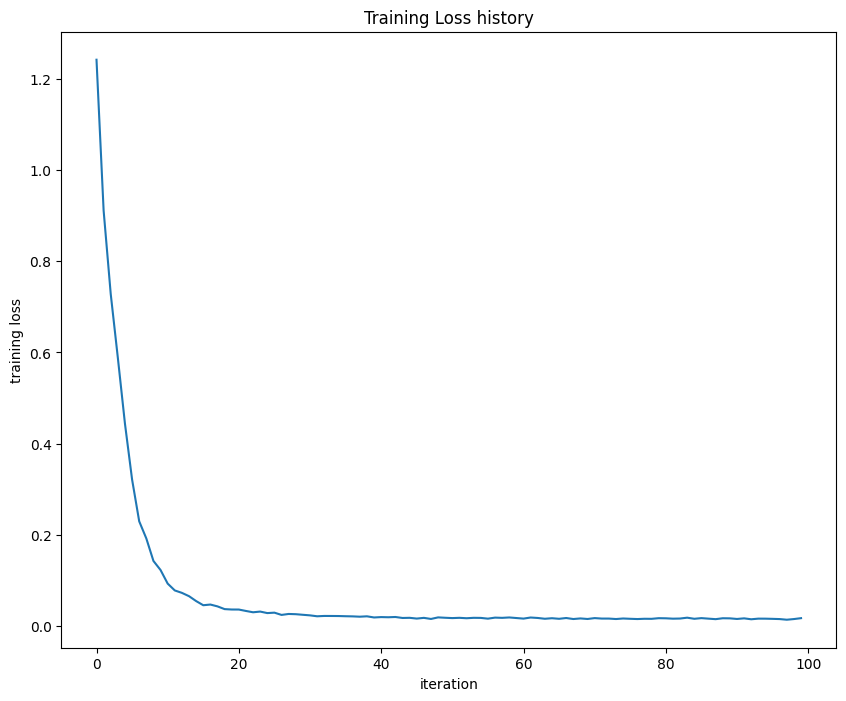

In [8]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6,
            num_iters=100, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])


plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

# Обучение нейронной сети на реальном наборе данных (CIFAR-10, MNIST)

Загрузите набор данных, соответствующий вашему варианту. 

Разделите данные на обучающую, тестовую и валидационную выборки.

Выполните предобработку данных, как в ЛР 1. 

Обучите нейронную сеть на ваших данных. 

При сдаче лабораторной работы объясните значения всех параметров метода train.

In [9]:
from sklearn.model_selection import train_test_split
import random
import numpy as np
import matplotlib.pyplot as plt
from scripts.data_utils import load_CIFAR10

cifar10_dir = 'scripts/datasets/cifar-10-batches-py'

try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Validate data shape: ', X_val.shape)
print('Validate labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (40000, 3072)
Training labels shape:  (40000,)
Validate data shape:  (10000, 3072)
Validate labels shape:  (10000,)
Test data shape:  (10000, 3072)
Test labels shape:  (10000,)


In [10]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

iteration 0 / 1000: loss 2.302986
iteration 100 / 1000: loss 2.301023
iteration 200 / 1000: loss 2.275240
iteration 300 / 1000: loss 2.171917
iteration 400 / 1000: loss 2.069444
iteration 500 / 1000: loss 2.010969
iteration 600 / 1000: loss 2.036640
iteration 700 / 1000: loss 2.043614
iteration 800 / 1000: loss 1.885211
iteration 900 / 1000: loss 2.019815
Validation accuracy:  0.2889


Используя параметры по умолчанию, вы можете получить accuracy, примерно равный 0.29. 

Проведите настройку гиперпараметров для увеличения accuracy. Поэкспериментируйте со значениями гиперпараметров, например, с количеством скрытых слоев, количеством эпох, скорости обучения и др. Ваша цель - максимально увеличить accuracy полносвязной сети на валидационном наборе. Различные эксперименты приветствуются. Например, вы можете использовать методы для сокращения размерности признакового пространства (например, PCA), добавить dropout слои и др. 

Для лучшей модели вычислите acсuracy на тестовом наборе. 

Для отладки процесса обучения часто помогают графики изменения loss и accuracy в процессе обучения. Ниже приведен код построения таких графиков. 

In [12]:
input_size = 32 * 32 * 3
hidden_sizes = [50, 200]
lerning_rates = [1e-4, 1e-7]
regs = [0.1, 0.01, 0.001]
batch_sizes = [200, 400]
nums_iters = [1000, 2500, 5000]
num_classes = 10

best_val_acc = 0
best_hidden_size = 0
best_lerning_rate = 0
best_reg = 0
best_batch_size = 0
best_num_iters = 0

for hidden_size in hidden_sizes:
    for rate in lerning_rates:
        for reg in regs:
            for batch_size in batch_sizes:
                for num_iters in nums_iters:
                    net = TwoLayerNet(input_size, hidden_size, num_classes)
                    
                    stats = net.train(X_train, y_train, X_val, y_val,
                                num_iters=num_iters,
                                batch_size=batch_size,
                                learning_rate=rate, 
                                learning_rate_decay=0.95,
                                reg=reg, verbose=True)
    
                    val_acc = (net.predict(X_val) == y_val).mean()
                    print(f"Validation accuracy: {val_acc}, learning_rate: {rate}, reg: {reg}, \
hidden_size: {hidden_size}, batch_size: {batch_size}, num_iters:{num_iters}")
    
                    if(best_val_acc < val_acc):
                        best_val_acc = val_acc
                        best_hidden_size = hidden_size
                        best_lerning_rate = rate 
                        best_reg = reg
                        best_batch_size = batch_size
                        best_num_iters = num_iters
                    
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

Validation accuracy: 0.2947, learning_rate: 0.0001, reg: 0.1, hidden_size: 50, batch_size: 200, num_iters:1000
Validation accuracy: 0.3649, learning_rate: 0.0001, reg: 0.1, hidden_size: 50, batch_size: 200, num_iters:2500
Validation accuracy: 0.4051, learning_rate: 0.0001, reg: 0.1, hidden_size: 50, batch_size: 200, num_iters:5000
Validation accuracy: 0.2923, learning_rate: 0.0001, reg: 0.1, hidden_size: 50, batch_size: 400, num_iters:1000
Validation accuracy: 0.3457, learning_rate: 0.0001, reg: 0.1, hidden_size: 50, batch_size: 400, num_iters:2500
Validation accuracy: 0.3643, learning_rate: 0.0001, reg: 0.1, hidden_size: 50, batch_size: 400, num_iters:5000
Validation accuracy: 0.3013, learning_rate: 0.0001, reg: 0.01, hidden_size: 50, batch_size: 200, num_iters:1000
Validation accuracy: 0.3648, learning_rate: 0.0001, reg: 0.01, hidden_size: 50, batch_size: 200, num_iters:2500
Validation accuracy: 0.4038, learning_rate: 0.0001, reg: 0.01, hidden_size: 50, batch_size: 200, num_iters:500

In [14]:
net = TwoLayerNet(input_size, best_hidden_size, num_classes)

stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=best_num_iters, batch_size=best_batch_size,
            learning_rate=best_lerning_rate, learning_rate_decay=0.95,
            reg=best_reg, verbose=True)

val_acc = (net.predict(X_val) == y_val).mean()
print(f"Validation accuracy: {val_acc}, learning_rate: {best_lerning_rate}, reg: {best_reg}, \
hidden_size: {best_hidden_size}, batch_size: {best_batch_size}, num_iters:{best_num_iters}")

iteration 0 / 5000: loss 2.302595
iteration 100 / 5000: loss 2.290648
iteration 200 / 5000: loss 2.218340
iteration 300 / 5000: loss 2.097516
iteration 400 / 5000: loss 2.017661
iteration 500 / 5000: loss 2.002951
iteration 600 / 5000: loss 2.070759
iteration 700 / 5000: loss 1.991816
iteration 800 / 5000: loss 2.007222
iteration 900 / 5000: loss 1.830530
iteration 1000 / 5000: loss 1.892676
iteration 1100 / 5000: loss 1.811462
iteration 1200 / 5000: loss 1.900376
iteration 1300 / 5000: loss 1.957160
iteration 1400 / 5000: loss 1.851885
iteration 1500 / 5000: loss 1.728238
iteration 1600 / 5000: loss 1.800679
iteration 1700 / 5000: loss 1.811091
iteration 1800 / 5000: loss 1.819834
iteration 1900 / 5000: loss 1.753523
iteration 2000 / 5000: loss 1.723282
iteration 2100 / 5000: loss 1.737228
iteration 2200 / 5000: loss 1.800388
iteration 2300 / 5000: loss 1.693904
iteration 2400 / 5000: loss 1.742553
iteration 2500 / 5000: loss 1.604547
iteration 2600 / 5000: loss 1.616168
iteration 270

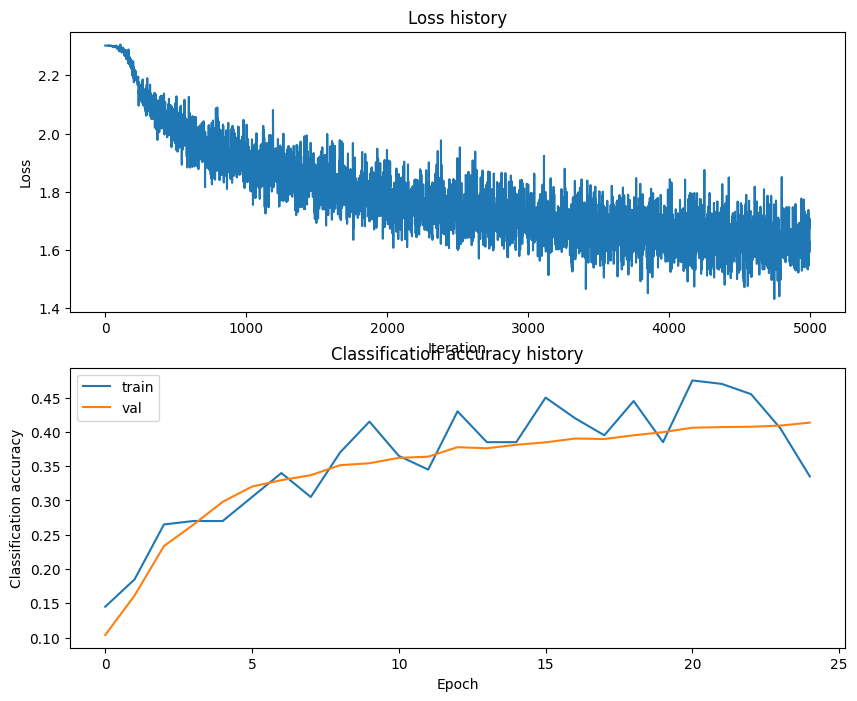

In [15]:
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

## vis_utils

In [16]:
from builtins import range
from past.builtins import xrange

from math import sqrt, ceil
import numpy as np

def visualize_grid(Xs, ubound=255.0, padding=1):
    """
    Reshape a 4D tensor of image data to a grid for easy visualization.

    Inputs:
    - Xs: Data of shape (N, H, W, C)
    - ubound: Output grid will have values scaled to the range [0, ubound]
    - padding: The number of blank pixels between elements of the grid
    """
    (N, H, W, C) = Xs.shape
    grid_size = int(ceil(sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size - 1)
    grid_width = W * grid_size + padding * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
                # grid[y0:y1, x0:x1] = Xs[next_idx]
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    # grid_max = np.max(grid)
    # grid_min = np.min(grid)
    # grid = ubound * (grid - grid_min) / (grid_max - grid_min)
    return grid

def vis_grid(Xs):
    """ visualize a grid of images """
    (N, H, W, C) = Xs.shape
    A = int(ceil(sqrt(N)))
    G = np.ones((A*H+A, A*W+A, C), Xs.dtype)
    G *= np.min(Xs)
    n = 0
    for y in range(A):
        for x in range(A):
            if n < N:
                G[y*H+y:(y+1)*H+y, x*W+x:(x+1)*W+x, :] = Xs[n,:,:,:]
                n += 1
    # normalize to [0,1]
    maxg = G.max()
    ming = G.min()
    G = (G - ming)/(maxg-ming)
    return G

def vis_nn(rows):
    """ visualize array of arrays of images """
    N = len(rows)
    D = len(rows[0])
    H,W,C = rows[0][0].shape
    Xs = rows[0][0]
    G = np.ones((N*H+N, D*W+D, C), Xs.dtype)
    for y in range(N):
        for x in range(D):
            G[y*H+y:(y+1)*H+y, x*W+x:(x+1)*W+x, :] = rows[y][x]
    # normalize to [0,1]
    maxg = G.max()
    ming = G.min()
    G = (G - ming)/(maxg-ming)
    return G


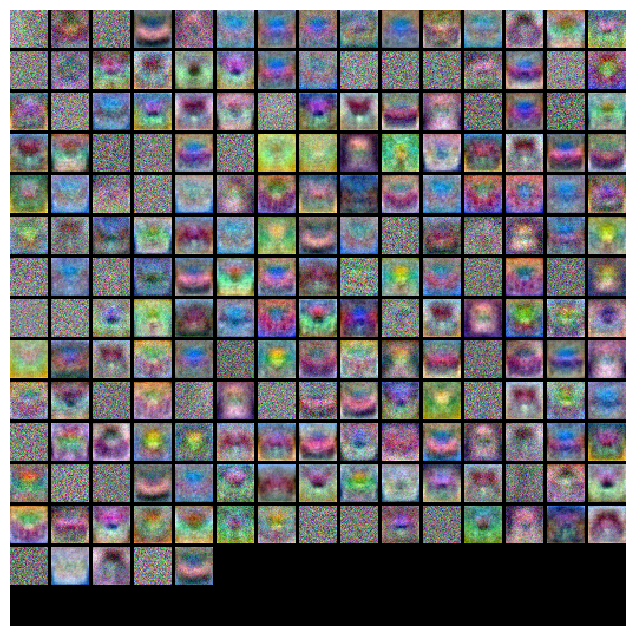

In [17]:
def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(net)

Сделайте выводы по результатам работы. 

В лабораторной работе была реализована двуслойная полносвязная нейронная сеть.

Точность зависит от гиперпараметров. Лучший результат  почти **42%** получен при следющих параметрах:

- `hidden_size` = 200
- `learning_rate` = 1e-4
- `reg` = 0.001
- `learning_rate_decay` = 0.95
- `num_iters` = 5000
- `batch_size` = 200

У параметров можно обнаружить сильную связанность, что усложняет процесс их подбора и занимает много времени.

Из первой и второй лабораторных работ можно сделать вывод о том, что с помощью двуслойной полносвязанной нейронной сети мы получили лучшую точность, чем с помощью методов машинного обучения.